In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

In [2]:
def preprocess_design_matrix(design_matrix):


    design_matrix = design_matrix[
        (design_matrix['verified_infection'] == 1) &
        (design_matrix['irrelevante_bacteremia'] == 0)
    ].copy()

    design_matrix['group'] = np.where(
        design_matrix['blood_culture_positive'] == 1, 2, 1
    )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [3]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]

    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix     


# Model Training

In [4]:
ms_data = pd.read_csv(
    "../0_data/proteins_train_filtered.tsv"
    , sep="\t"
)

In [5]:
design_matrix_otrain = pd.read_csv(
    "../0_data/design_matrix_train.tsv",
    sep='\t'
)

In [6]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

<Axes: xlabel='blood_culture_positive', ylabel='Count'>

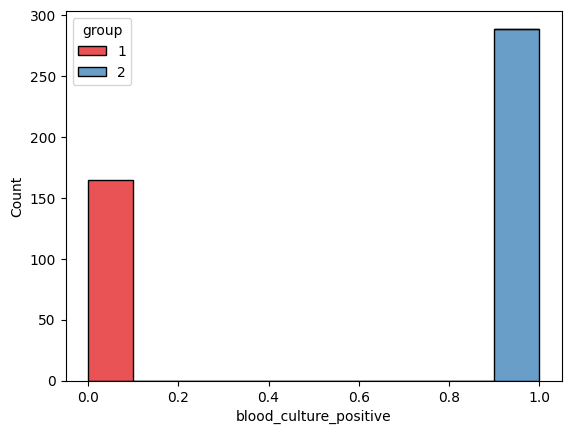

In [7]:
sns.histplot(
    design_matrix_train,
    x="blood_culture_positive",
    hue="group",
    palette="Set1",
    multiple="stack"
)

In [8]:
design_matrix_train['group'].value_counts()

group
2    289
1    165
Name: count, dtype: int64

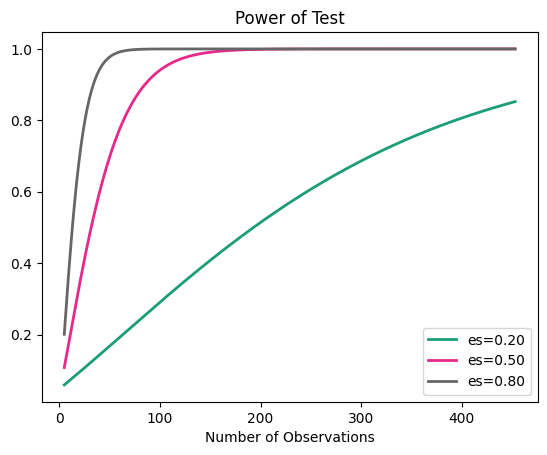

In [9]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

# parameters for power analysis
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, design_matrix_train.shape[0]))


analysis = TTestIndPower()

analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [10]:
quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [11]:
quant_matrix_train = quant_matrix_train.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [12]:
quant_matrix_train.write("de_results/bacteremia_de_proteins.tsv")

In [13]:
quant_matrix_de = quant_matrix_train.to_df()

<Axes: xlabel='Log2FoldChange2-1', ylabel='-Log10CorrectedPValue2-1'>

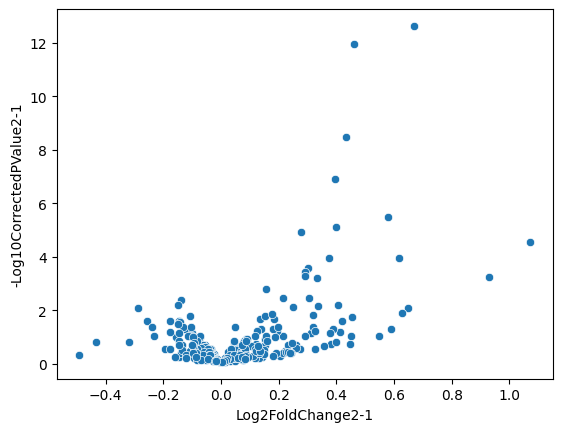

In [14]:
sns.scatterplot(
    data=quant_matrix_de,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1"
)

In [15]:
qm_filtered = (
    
    QuantMatrix(
        quantification_file=quant_matrix_de,
        design_matrix_file=design_matrix_train
    )
    
)

In [16]:
training_data, y = qm_filtered.to_ml(feature_column="ProteinLabel")

In [17]:
protein_columns = training_data.columns.to_list()

In [18]:
len(protein_columns)

287

In [19]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

X = training_data.copy()

protein_scaler = StandardScaler()

X[protein_columns] = protein_scaler.fit_transform(X[protein_columns])

X = X.copy()

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    random_state=42,
    #penalty="l1",
    class_weight="balanced",
    #C=0.1,
    #solver="liblinear",
    max_iter=1000
)

# protein_clf = BaggingClassifier(
#     estimator=protein_clf
# )

In [21]:
y['label'].value_counts()

label
1    289
0    165
Name: count, dtype: int64

In [22]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight


class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y.values.ravel()),
    y=y.values.ravel()
)

class_weight = dict(zip(np.unique(y.values.ravel()), class_weight))

class_weight

{0: 1.3757575757575757, 1: 0.7854671280276817}

In [23]:
# sample_weight = compute_sample_weight(
#     class_weight=class_weight,
#     y=y.values.ravel()
# )

In [24]:
from mrmr import mrmr_classif
selected_proteins = mrmr_classif(X=X[protein_columns], y=y.values.ravel(), K=50)

100%|██████████| 50/50 [00:20<00:00,  2.42it/s]


In [25]:
selected_proteins

['C163A_HUMAN',
 'FCN3_HUMAN',
 'FIBA_HUMAN',
 'FCG3A_HUMAN',
 'VWF_HUMAN',
 'APOA_HUMAN',
 'CATB_HUMAN',
 'HABP2_HUMAN',
 'ICAM1_HUMAN',
 'IBP7_HUMAN',
 'VCAM1_HUMAN',
 'VSIG4_HUMAN',
 'CAMP_HUMAN',
 'A2AP_HUMAN',
 'TIMP1_HUMAN',
 'PXDC2_HUMAN',
 'PLTP_HUMAN',
 'CSPG2_HUMAN',
 'NOE1_HUMAN',
 'CATD_HUMAN',
 'CO6A3_HUMAN',
 'CSF1R_HUMAN',
 'PLMN_HUMAN',
 'H4_HUMAN',
 'LYSC_HUMAN',
 'FHR4_HUMAN',
 'TSP4_HUMAN',
 'SAA4_HUMAN',
 'CYTC_HUMAN',
 'AMPN_HUMAN',
 'CD44_HUMAN',
 'ALS_HUMAN',
 'G3P_HUMAN',
 'CO6A1_HUMAN',
 'FCN2_HUMAN',
 'CADH1_HUMAN',
 'CHLE_HUMAN',
 'FETUB_HUMAN',
 'S10A9_HUMAN',
 'COMP_HUMAN',
 'ALDOB_HUMAN',
 'B2MG_HUMAN',
 'APOL1_HUMAN',
 'CFAD_HUMAN',
 'NRP1_HUMAN',
 'FA11_HUMAN',
 'GSTO1_HUMAN',
 'FBLN3_HUMAN',
 'CNDP1_HUMAN',
 'CXCL7_HUMAN']

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, HistGradientBoostingClassifier


protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [27]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3)
eval_result = cross_validate(
    protein_clf, X[selected_proteins], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.6610466781214205,
 0.7591942820012996,
 0.6497763448355989,
 0.6456748542122254)

In [28]:
from dpks.interpretation import BootstrapInterpreter

protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_proteins,
    downsample_background=True,
    shuffle_iterations=100
)

In [29]:
protein_interpreter.fit(X[selected_proteins].values, y.values.ravel(), protein_clf)

In [30]:
protein_importances = protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [31]:
protein_importances.head(20)

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
0,C163A_HUMAN,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,...,0.990448,2.0,1.000000,1.0,0.841495,0.995224,0.253017,4.11,1.5,7.468310
41,B2MG_HUMAN,0.568776,3.0,0.618291,4.0,0.327794,12.0,0.360311,7.0,0.544914,...,0.673469,4.0,0.385361,7.0,0.644805,0.663924,0.296636,7.54,4.0,10.574813
7,HABP2_HUMAN,0.393992,4.0,0.769227,2.0,0.529981,6.0,0.608568,2.0,0.253364,...,0.666661,5.0,0.159392,26.0,0.578472,0.572756,0.242503,7.08,4.0,7.818238
47,FBLN3_HUMAN,0.799077,2.0,0.129944,31.0,0.601485,5.0,0.306991,11.0,0.237742,...,0.215442,23.0,0.646443,2.0,0.490619,0.451014,0.289989,12.28,6.0,13.216977
3,FCG3A_HUMAN,0.372569,6.0,0.275213,17.0,0.364268,10.0,0.187555,27.0,0.291551,...,0.776918,3.0,0.463951,3.0,0.456027,0.406951,0.229815,10.80,7.0,9.497474
28,CYTC_HUMAN,0.363343,7.0,0.095721,40.0,0.251998,17.0,0.203981,23.0,0.067304,...,0.473774,12.0,0.254594,16.0,0.407820,0.385224,0.278300,16.22,11.5,14.560622
10,VCAM1_HUMAN,0.200602,17.0,0.306778,13.0,0.703782,3.0,0.246223,20.0,0.561622,...,1.000000,1.0,0.111746,33.0,0.390095,0.367909,0.238647,15.21,10.5,13.416630
49,CXCL7_HUMAN,0.274990,8.0,0.289456,16.0,0.396007,8.0,0.031030,45.0,0.113726,...,0.385763,14.0,0.372630,8.0,0.342278,0.336257,0.190804,16.26,11.0,12.559048
43,CFAD_HUMAN,0.244141,11.0,0.416193,6.0,0.278864,14.0,0.386359,5.0,0.337063,...,0.249843,17.0,0.262038,15.0,0.291060,0.237707,0.229503,21.60,19.0,14.780550
36,CHLE_HUMAN,0.188609,19.0,0.124668,32.0,0.068080,41.0,0.203308,24.0,0.067342,...,0.652531,6.0,0.399103,6.0,0.283137,0.276889,0.189853,20.64,16.5,13.951952


In [32]:
selected_proteins = protein_importances.head(10)['feature'].to_list()

In [33]:
from dpks.interpretation import Classifier


protein_clf = Classifier(protein_clf)

In [34]:
selected_features = selected_proteins[:10]

In [35]:
for feature in selected_features:

    print(feature)

C163A_HUMAN
B2MG_HUMAN
HABP2_HUMAN
FBLN3_HUMAN
FCG3A_HUMAN
CYTC_HUMAN
VCAM1_HUMAN
CXCL7_HUMAN
CFAD_HUMAN
CHLE_HUMAN


In [36]:
protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [37]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[selected_features], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.6680269186712485,
 0.7985606278112738,
 0.6807830835366562,
 0.6855286108507759)

In [38]:
cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[protein_columns], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.6991337342497137,
 0.7437600905264373,
 0.6541913558731265,
 0.6374456550036447)

In [39]:
from dpks.interpretation import BootstrapInterpreter

final_protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_features,
    downsample_background=True,
    shuffle_iterations=100
)

In [40]:
final_protein_interpreter.fit(X[selected_features].values, y.values.ravel(), protein_clf)

In [41]:
final_protein_importances = final_protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [42]:
final_protein_importances

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
0,C163A_HUMAN,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,...,1.000000,1.0,1.000000,1.0,0.869802,1.000000,0.199166,2.05,1.0,1.552938
1,B2MG_HUMAN,0.499838,4.0,0.604366,3.0,0.632771,2.0,0.214761,7.0,0.729615,...,0.920528,2.0,0.989583,2.0,0.710873,0.735306,0.262706,3.03,2.0,2.012361
5,CYTC_HUMAN,0.608614,2.0,0.453397,4.0,0.630084,3.0,0.002255,10.0,0.116282,...,0.912478,3.0,0.718006,4.0,0.618027,0.630874,0.284798,4.03,3.0,2.418176
2,HABP2_HUMAN,0.357752,5.0,0.897978,2.0,0.421690,5.0,0.475691,3.0,0.568159,...,0.607497,4.0,0.386704,7.0,0.547253,0.515498,0.156251,4.11,4.0,1.441765
4,FCG3A_HUMAN,0.247470,6.0,0.435384,5.0,0.464339,4.0,0.223915,6.0,0.489285,...,0.597221,5.0,0.737276,3.0,0.522229,0.494129,0.218414,4.41,4.0,1.842786
8,CFAD_HUMAN,0.202310,7.0,0.189797,6.0,0.345836,7.0,0.430473,4.0,0.522906,...,0.153721,9.0,0.599305,6.0,0.362789,0.314279,0.248518,6.26,7.0,2.393679
3,FBLN3_HUMAN,0.561286,3.0,0.020668,8.0,0.400485,6.0,0.339985,5.0,0.041322,...,0.306140,7.0,0.609673,5.0,0.343427,0.343450,0.205093,6.52,6.0,2.052247
9,CHLE_HUMAN,0.073856,9.0,0.013922,9.0,0.246707,9.0,0.084682,9.0,0.021730,...,0.446624,6.0,0.334778,8.0,0.205908,0.172226,0.146456,8.04,8.0,1.722812
7,CXCL7_HUMAN,0.069488,10.0,0.011007,10.0,0.299174,8.0,0.148360,8.0,0.021276,...,0.131716,10.0,0.196397,10.0,0.189881,0.170150,0.123456,8.18,8.0,1.539907
6,VCAM1_HUMAN,0.077940,8.0,0.081561,7.0,0.015028,10.0,0.560777,2.0,0.126257,...,0.256197,8.0,0.245454,9.0,0.170470,0.133544,0.148100,8.37,9.0,1.738774


In [43]:
final_protein_importances.to_csv(
    "feature_importances/bacteremia_protein_importances.tsv",
    sep="\t",
    index=False
)

# Model Testing

In [44]:
ms_data_test = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [45]:
design_matrix_test = preprocess_design_matrix(design_matrix_test)

quant_matrix_test = preprocess_data(ms_data_test, design_matrix=design_matrix_test)

In [46]:
quant_matrix_test_df = quant_matrix_test.to_df()
#quant_matrix_test_df = quant_matrix_test_df[quant_matrix_test_df['ProteinLabel'].isin(selected_features)]

In [47]:
qm_filtered_test = (
    
    QuantMatrix(
        quantification_file=quant_matrix_test_df,
        design_matrix_file=design_matrix_test
    )
    
)

In [48]:
testing_data, y_test = qm_filtered_test.to_ml(feature_column="ProteinLabel")

In [49]:
X_test = testing_data.copy()

X_test[protein_scaler.feature_names_in_] = protein_scaler.transform(X_test[protein_scaler.feature_names_in_])

X_test = X_test.copy()

In [50]:
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

decision_tree = DecisionTreeClassifier(random_state=42)

random_forest = RandomForestClassifier(random_state=42)

svc = SVC(random_state=42)
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
mlp = MLPClassifier(random_state=42)


lr_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)



# lr_clf = GradientBoostingClassifier(
#     #estimator=random_forest,
#     random_state=42
# )

xgb_clf = XGBClassifier(
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    learning_rate=0.01,
    n_estimators=1000,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_jobs=1
)




In [51]:
lr_clf.fit(X[selected_features], y.values.ravel(), )
xgb_clf.fit(X[selected_features], y.values.ravel(), )
decision_tree.fit(X[selected_features], y.values.ravel(), ) 
random_forest.fit(X[selected_features], y.values.ravel(), )
svc.fit(X[selected_features], y.values.ravel(), )
knn.fit(X[selected_features], y.values.ravel()) 
naive_bayes.fit(X[selected_features], y.values.ravel(), ) 
mlp.fit(X[selected_features], y.values.ravel())

MLPClassifier(random_state=42)

In [52]:
from sklearn.metrics import f1_score

lr_predictions = lr_clf.predict(X_test[selected_features])
lr_ba = f1_score(y_test.values.ravel(), lr_predictions)

xgb_predictions = xgb_clf.predict(X_test[selected_features])
xgb_ba = f1_score(y_test.values.ravel(), xgb_predictions)

decision_tree_predictions = decision_tree.predict(X_test[selected_features])
decision_tree_ba = f1_score(y_test.values.ravel(), decision_tree_predictions)

rf_predictions = random_forest.predict(X_test[selected_features])
rf_ba = f1_score(y_test.values.ravel(), rf_predictions)

svc_predictions = svc.predict(X_test[selected_features])
svc_ba = f1_score(y_test.values.ravel(), svc_predictions)

knn_predictions = knn.predict(X_test[selected_features])
knn_ba = f1_score(y_test.values.ravel(), knn_predictions)

nb_predictions = naive_bayes.predict(X_test[selected_features])
nb_ba = f1_score(y_test.values.ravel(), nb_predictions)

mlp_predictions = mlp.predict(X_test[selected_features])
mlp_ba = f1_score(y_test.values.ravel(), mlp_predictions)

In [53]:
lr_ba, xgb_ba, decision_tree_ba, rf_ba, svc_ba, knn_ba, nb_ba, mlp_ba

(0.6956521739130435,
 0.7132867132867133,
 0.6618181818181819,
 0.7256944444444444,
 0.7532894736842105,
 0.7239057239057239,
 0.6773547094188377,
 0.7226277372262774)

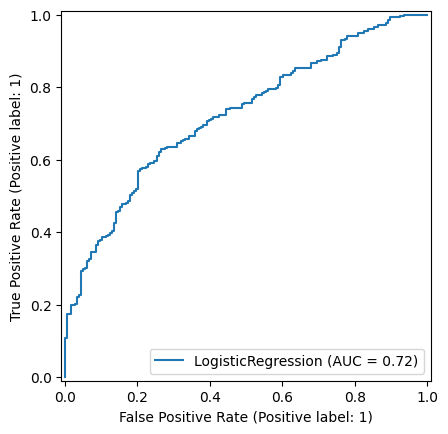

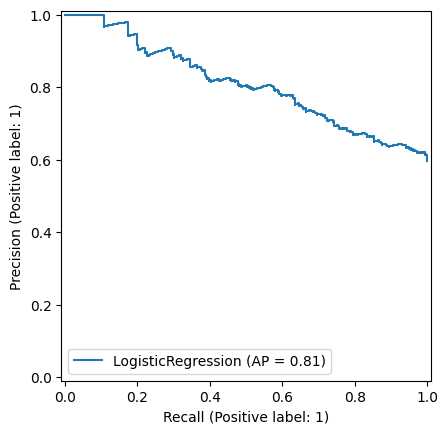

In [54]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)


PrecisionRecallDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)





In [55]:
from sklearn.metrics import roc_curve

y_probs = lr_clf.predict_proba(X_test[selected_features])[:, 1]

# Compute ROC curve metrics
fpr, tpr, thresholds = roc_curve( y_test.values.ravel(), y_probs)

# Create a DataFrame to store the metrics
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})


In [56]:
roc_df.to_csv(
    "roc/bacteremia.tsv",
    sep="\t"
)

# Probability Prediction

In [57]:
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

design_matrix_test['sample'] = design_matrix_test['injection']
design_matrix_test['group'] = 1

quant_matrix_predict = QuantMatrix(
    quantification_file=ms_data_test,
    design_matrix_file=design_matrix_test,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
).impute(method="uniform_percentile", percentile=0.01)

predict_data, y_test_alll = quant_matrix_predict.to_ml(feature_column="ProteinLabel")

In [58]:
predict_data = predict_data[protein_columns].copy()

In [59]:
predict_data[protein_columns] = protein_scaler.transform(predict_data[protein_columns])

In [60]:
predict_data['bacteremia_probability'] = lr_clf.predict_proba(predict_data[selected_features])[:, 1]

In [61]:
design_matrix_test = design_matrix_test.set_index("injection").join(
    predict_data['bacteremia_probability']
).reset_index()

In [62]:
predict_data[['bacteremia_probability']].to_csv(
    "predictions_test/bacteremia.tsv",
    sep="\t"
)

<Axes: xlabel='bacteremia_probability', ylabel='Count'>

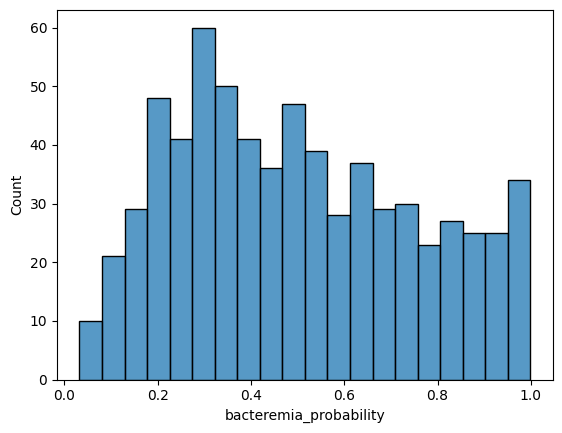

In [63]:
sns.histplot(
    data=design_matrix_test,
    x="bacteremia_probability",
    #hue="sofa_bacteremia_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [64]:
ms_data_val = pd.read_csv(
    "../0_data/proteins_val_filtered.tsv"
    , sep="\t"
)

design_matrix_val = pd.read_csv(
    "../0_data/design_matrix_validation.tsv",
    sep='\t'
)

design_matrix_val['sample'] = design_matrix_val['injection']
design_matrix_val['group'] = 1

quant_matrix_val = QuantMatrix(
    quantification_file=ms_data_val,
    design_matrix_file=design_matrix_val,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

val_data, y_val = quant_matrix_val.to_ml(feature_column="ProteinLabel")

In [65]:
val_data = val_data[protein_columns].copy()

In [66]:
val_data[protein_columns] = protein_scaler.transform(val_data[protein_columns])

In [67]:
val_data['bacteremia_probability'] = lr_clf.predict_proba(val_data[selected_features])[:, 1]

In [68]:
design_matrix_val = design_matrix_val.set_index("injection").join(
    val_data['bacteremia_probability']
).reset_index()

In [69]:
val_data[['bacteremia_probability']].to_csv(
    "predictions_val/bacteremia.tsv",
    sep="\t"
)

<Axes: xlabel='bacteremia_probability', ylabel='Count'>

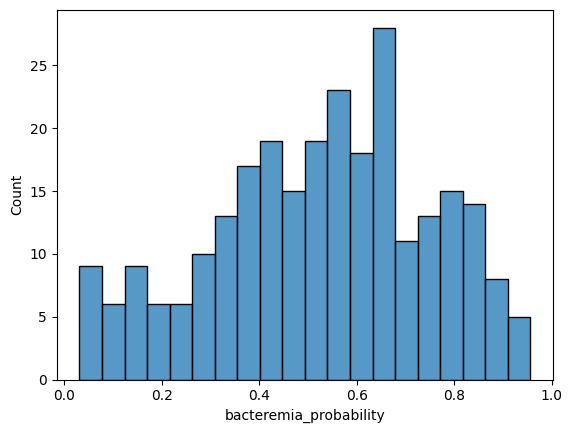

In [70]:
sns.histplot(
    data=design_matrix_val,
    x="bacteremia_probability",
    #hue="sofa_bacteremia_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [71]:
ms_data_hero = pd.read_csv(
    "../0_data/proteins_hero_filtered.tsv"
    , sep="\t"
)

design_matrix_hero = pd.read_csv(
    "../0_data/design_matrix_hero.tsv",
    sep='\t'
)

design_matrix_hero['sample'] = design_matrix_hero['injection']
design_matrix_hero['group'] = 1

quant_matrix_hero = QuantMatrix(
    quantification_file=ms_data_hero,
    design_matrix_file=design_matrix_hero,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

hero_data, y_hero = quant_matrix_hero.to_ml(feature_column="ProteinLabel")

In [72]:
hero_data = hero_data[protein_columns].copy()

In [73]:
hero_data[protein_columns] = protein_scaler.transform(hero_data[protein_columns])

In [74]:
hero_data['bacteremia_probability'] = lr_clf.predict_proba(hero_data[selected_features])[:, 1]

In [75]:
design_matrix_hero = design_matrix_hero.set_index("injection").join(
    hero_data['bacteremia_probability']
).reset_index()

In [76]:
hero_data[['bacteremia_probability']].to_csv(
    "predictions_external/bacteremia.tsv",
    sep="\t"
)

<Axes: xlabel='bacteremia_probability', ylabel='Count'>

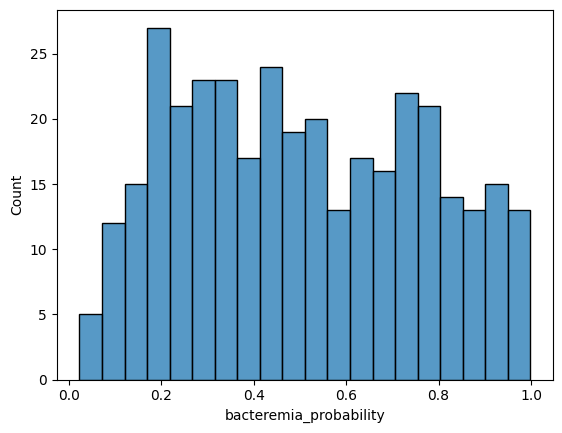

In [77]:
sns.histplot(
    data=hero_data,
    x="bacteremia_probability",
    #hue="sofa_bacteremia_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [78]:
from joblib import dump


with open("models/bacteremia_protein_model.pkl", "wb") as f:

    dump(lr_clf, f)

with open("models/bacteremia_protein_scaler.pkl", "wb") as f:

    dump(protein_scaler, f)
